In [2]:
!ls /home/jupyter/datasphere/s3/garbage-data/generated-data/generated_roman_last_version/DJI_0001#cd#_1342081c-9503-4fc4-b777-673655cb6110

class_0.png
class_1.png
class_2.png
class_3.png
class_4.png
class_5.png
image.jpeg


In [3]:
gen_path = '/home/jupyter/datasphere/s3/garbage-data/generated-data/generated_roman_last_version'
ex1_path = '/home/jupyter/datasphere/s3/garbage-data/generated-data/generated_roman_last_version/DJI_0001#cd#_1342081c-9503-4fc4-b777-673655cb6110'
img_path = os.path.join(ex1_path, 'image.jpeg')
cls1_path = os.path.join(ex1_path, 'class_1.png')

In [35]:
import os
import numpy as np
from PIL import Image

In [72]:
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


SUFFIXES = {"png", "jpg", "jpeg", "JPEG", "JPG"}
PREFFIXES = {"DJI"}

def image_coroutine(dir_link, default_name, image_type):
    image_links = sorted([l for l in os.listdir(dir_link) if l[:3] in PREFFIXES])
    for i, il in enumerate(image_links):
        image_path = os.path.join(dir_link, il, default_name)

        if image_type == 'mask':
            img = Image.open(image_path)
        else:
            img = Image.open(image_path).convert("RGB")
        img = np.asarray(img)

        yield img


def crop_coroutine(img, size=256):
    rows, cols = img.shape[:2]
    rows, cols = rows // 256, cols // 256

    for row in range(rows):
        for col in range(cols):
            crop = img[size * row : size * (row + 1), size * col : size * (col + 1)]

            yield crop


def one_dataset_coroutine(dir_link, default_names, image_types, n=np.inf):
    number = 0
    cors = [
        image_coroutine(dir_link, default_name=dn, image_type=it) 
        for dn, it in zip(default_names, image_types)
    ]

    try:
        while True:
            imgs = [next(cor) for cor in cors]
            crop_cors = [crop_coroutine(img) for img in imgs]

            try:
                while True:
                    crops = [next(crop_cor) for crop_cor in crop_cors]
                    number += 1
                    yield crops
                    if number == n:
                        return number
            except StopIteration:
                continue
    except StopIteration:
        pass

    return number


def dataset_coroutine(links_list, default_names, image_types, each_n=None, total_n=np.inf):
    number = 0
    ns_list = []
    if isinstance(each_n, (int, float)):
        ns_list = [each_n] * len(links_list)
    if isinstance(each_n, list):
        assert len(each_n) == len(links_list)
        ns_list = each_n

    for ni, link in zip(ns_list, links_list):
        ni = min(ni, total_n)
        print(ni)
        odc = one_dataset_coroutine(link, default_names, image_types, ni)
        odc_number = yield from odc

        print('odc_number: ', odc_number)

        number += odc_number
        total_n -= odc_number
        if total_n == 0:
            break

    print('total_number: ', number)
    return number

In [81]:
odc = dataset_coroutine(
    links_list=['/home/jupyter/datasphere/s3/garbage-data/generated-data/generated_roman_last_version'],
    default_names=[f'class_{i}.png' for i in range(6)] + ['image.jpeg'],
    image_types=['mask'] * 6 + ['image'],
    each_n=7,
    total_n=np.inf
)

7


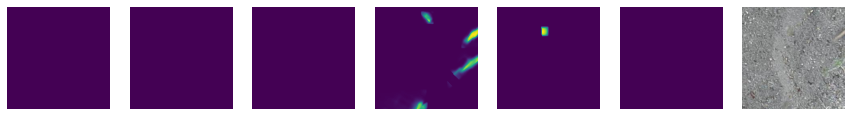

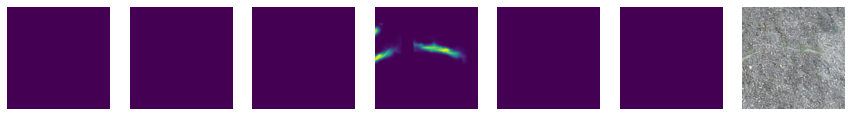

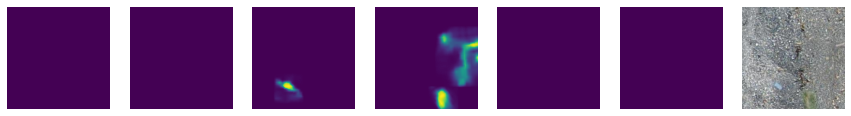

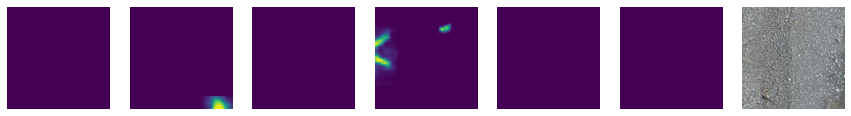

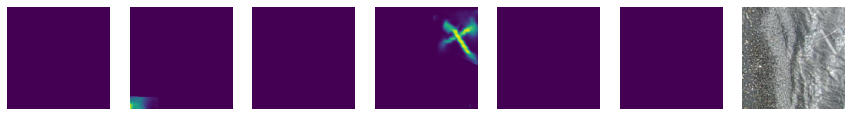

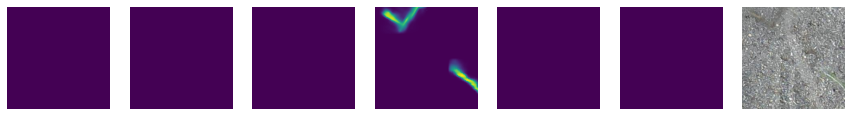

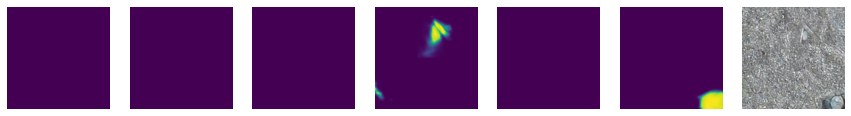

odc_number:  7
total_number:  7


In [82]:
for out in odc:
    fig, axes = plt.subplots(ncols=7, figsize=(15, 3))

    for i in range(len(axes)):
        axes[i].imshow(out[i])
        axes[i].axis('off')

    plt.show()